# Import

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [76]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy.stats import shapiro
from scipy.stats import probplot
from scipy import stats

In [77]:
df = pd.read_csv('indego_daily_trips.csv')

In [78]:
df['date'] = pd.to_datetime(df['date'])
df['ds'] = df['date']
df['y'] = df['trips']

# Train Test Split

In [79]:
train_size = len(df) - (365)
train = df[:train_size]
test = df[train_size:]

# Stationarity Checks

Text(0.5, 1.0, 'Indego Daily Ridership')

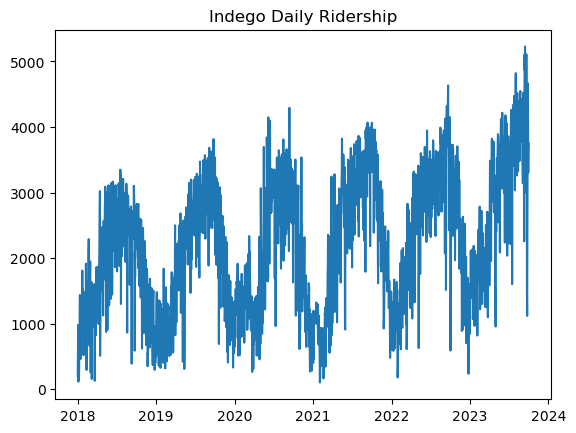

In [80]:
plt.plot(train['date'], train['trips'])
plt.title('Indego Daily Ridership')

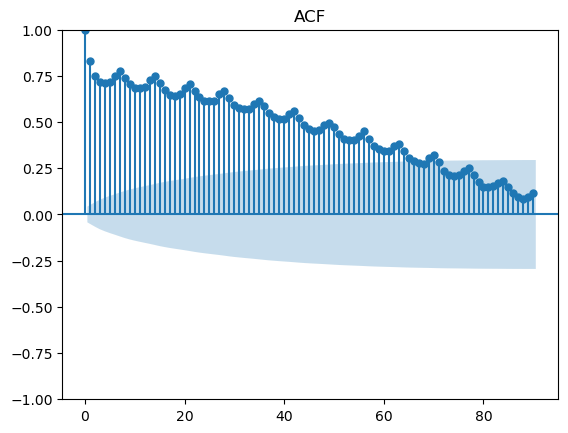

In [81]:
plot_acf(train['trips'], lags=90)
plt.title('ACF')
plt.show()

Text(0.5, 1.0, 'PACF')

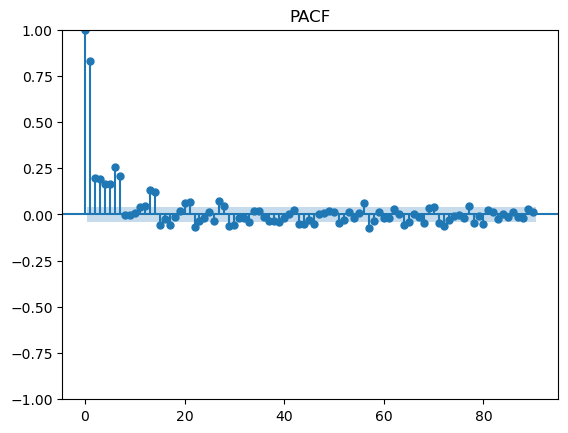

In [82]:
plot_pacf(train['trips'], lags=90)
plt.title('PACF')

In [83]:
result = adfuller(df['trips'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
#Conclude not stationary

ADF Statistic: -2.141162429906141
p-value: 0.22828818961852904


# Model Building

In [147]:
# Python
model = Prophet(changepoint_prior_scale=0.5, interval_width=0.99)
model.add_country_holidays(country_name='US')
model.fit(train_df)
predict = model.predict(train_df)
train['y_pred'] = predict['yhat']
train['residuals'] = train['y'] - train['y_pred']

15:51:26 - cmdstanpy - INFO - Chain [1] start processing
15:51:26 - cmdstanpy - INFO - Chain [1] done processing
/var/folders/7r/1p6kjcd133s6g0q2q5hnww4c0000gn/T/ipykernel_26067/1453947537.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y_pred'] = predict['yhat']
/var/folders/7r/1p6kjcd133s6g0q2q5hnww4c0000gn/T/ipykernel_26067/1453947537.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['residuals'] = train['y'] - train['y_pred']


In [148]:
mape = mean_absolute_percentage_error(train['y'], train['y_pred']) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 27.38%


# Residual Analysis

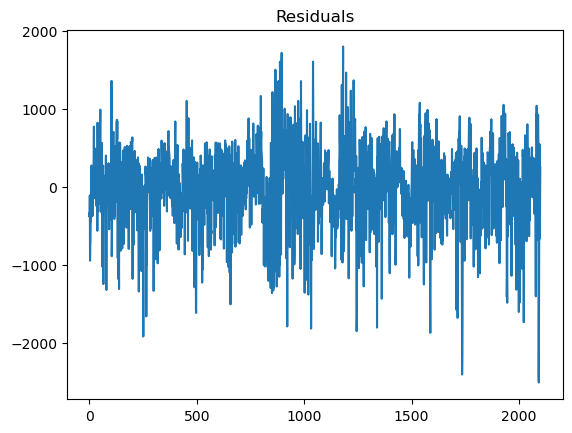

In [149]:
plt.plot(train['residuals'])
plt.title('Residuals')
plt.show()

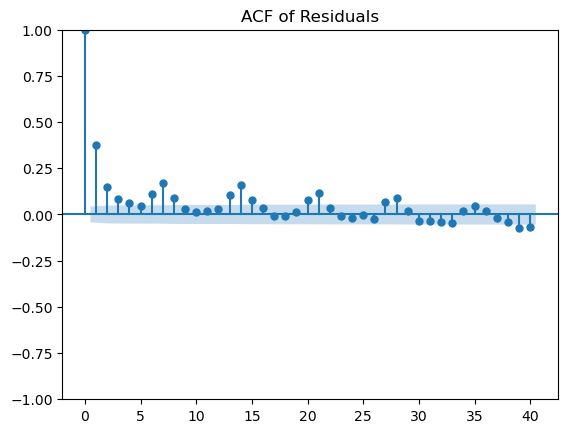

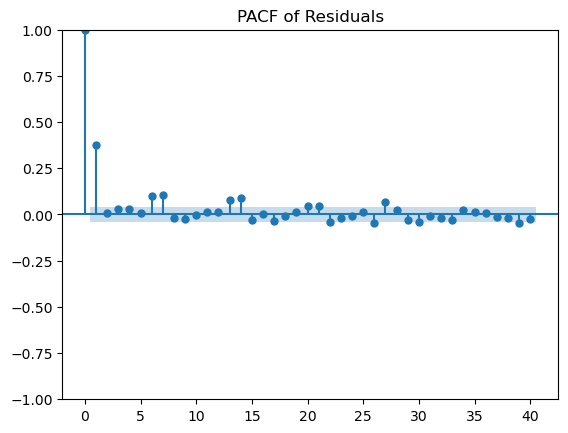

In [150]:
plot_acf(train['residuals'], lags=40)
plt.title('ACF of Residuals')
plt.show()
plot_pacf(train['residuals'], lags=40)
plt.title('PACF of Residuals')
plt.show()

In [151]:
result = adfuller(train['residuals'])
print(f'ADF Statistic: {result[0]:.4f}')
print(f'P-value: {result[1]:.4f}')
#Conclude residuals are stationary

ADF Statistic: -6.9719
P-value: 0.0000


In [152]:
stat, p = runstest_1samp(train['residuals'])
print(f"Z-statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")
#Conclude residuals are not random

Z-statistic: -11.9248
P-value: 0.0000


In [153]:
stat, p = shapiro(train['residuals'])
print(f"Shapiro-Wilk Test Statistic: {stat:.4f}")
print(f"P-value: {p:.4f}")
#Conclude residuals are not normally distributed

Shapiro-Wilk Test Statistic: 0.9705
P-value: 0.0000


Text(0.5, 1.0, 'Q-Q Plot')

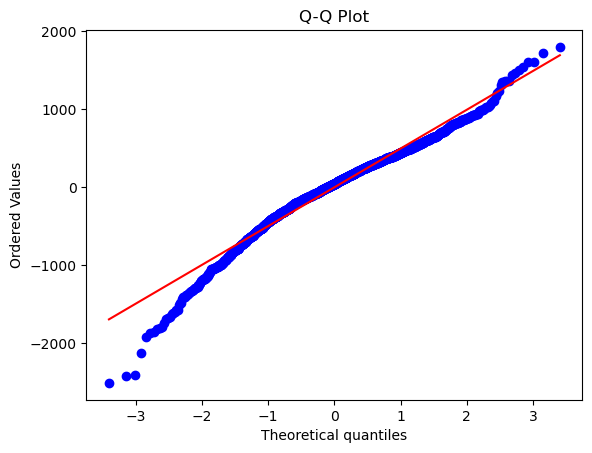

In [154]:
probplot(train['residuals'], dist="norm", plot=plt)
plt.title("Q-Q Plot")

(array([  4.,  10.,  31., 110., 259., 685., 749., 219.,  25.,   8.]),
 array([-2508.41686258, -2077.57951713, -1646.74217168, -1215.90482622,
         -785.06748077,  -354.23013532,    76.60721013,   507.44455558,
          938.28190104,  1369.11924649,  1799.95659194]),
 <BarContainer object of 10 artists>)

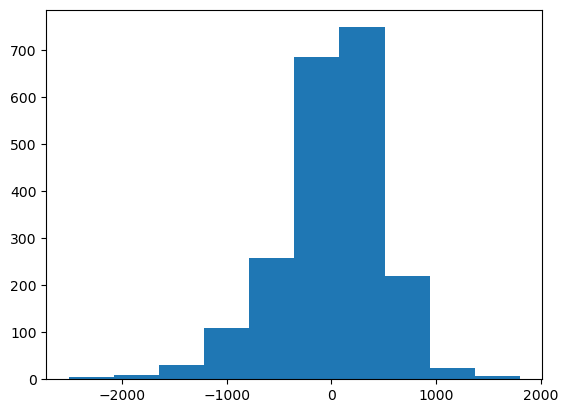

In [155]:
plt.hist(train['residuals'])

# Model Testing

In [156]:
future = model.make_future_dataframe(periods=(365), freq='D')
y_pred = model.predict(future)
test['y_pred'] = y_pred['yhat'].tail(365)

/var/folders/7r/1p6kjcd133s6g0q2q5hnww4c0000gn/T/ipykernel_26067/2639652327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['y_pred'] = y_pred['yhat'].tail(365)


In [157]:
mape = mean_absolute_percentage_error(test['y'], test['y_pred']) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 24.44%


# Forecast

16:02:22 - cmdstanpy - INFO - Chain [1] start processing
16:02:22 - cmdstanpy - INFO - Chain [1] done processing


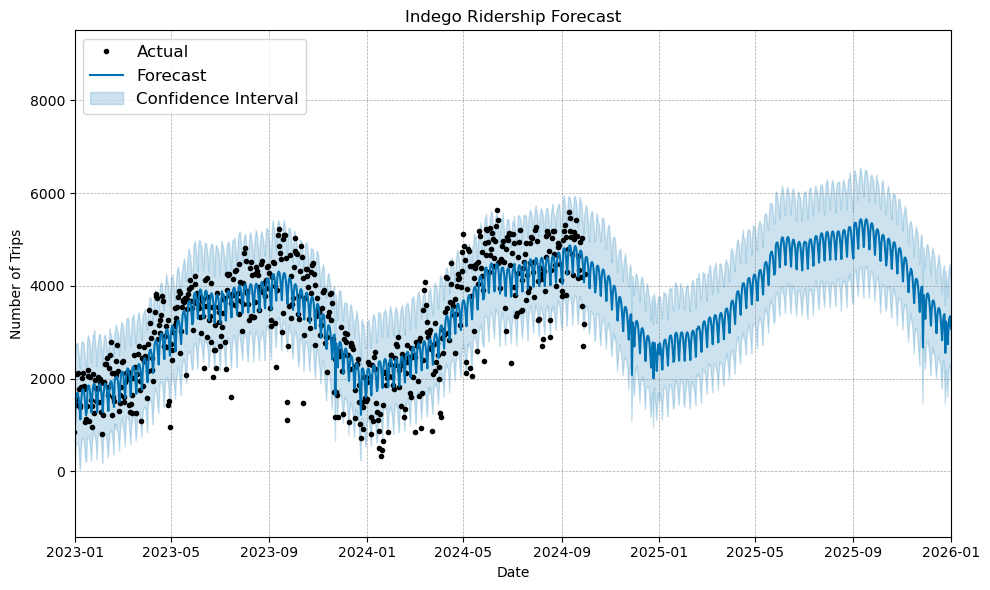

In [184]:
model = Prophet(interval_width=0.95)
model.add_country_holidays(country_name='US')
model.fit(df)
future = model.make_future_dataframe(periods=1919, freq='D')
y_pred = model.predict(future)
fig = model.plot(y_pred)
plt.title('Indego Ridership Forecast')
plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2026-01-01'))
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(['Actual', 'Forecast', 'Confidence Interval'], loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()

In [186]:
y_pred.to_csv('indego_forecast.csv', index=False)